# Predict the invariants of number fields

In this notebook, we will build a decision tree model that predicts 

1) rank of the unit group $\mathcal{O}_K^\times$ of a quadratic field $K$ (or equivalently, signature of a quadratic field) from polynomial coefficients

2) Galois group of quartic Galois extensions from Dedekind zeta coefficients.

In [1]:
import pathlib

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree, _tree
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import polars as pl
from tqdm import tqdm

from lmf import db

In [2]:
nf_db = db.nf_fields

Q1. Using Sage, you can compute several invariants of number fields.

Consider the degree 8 number field
$$
K = \mathbb{Q}[x] / (x^8 - 6x^6 - 4x^5 + 43x^4 + 104x^3 + 86x^2 + 24x + 36)
$$

1. Find the signature, discrimiannt, ramified primes, Galois group, and class number of $K$.

2. Is the field Galois over $\mathbb{Q}$?

3. Find the intermediate fields between $K$ and $\mathbb{Q}$.

4. Find the smallest rational prime $p$ that splits completely in $K$.

5. Find the LMFDB label of this number field.

In [3]:
x = polygen(QQ)
K.<a> = NumberField(x^8 - 6*x^6 - 4*x^5 + 43*x^4 + 104*x^3 + 86*x^2 + 24*x + 36)

print(f"Signature: {K.signature()}")
print(f"Discriminant: {K.disc()}")
print(f"Ramified primes: {K.disc().support()}")
print(f"Galois group: {K.galois_group()}")
print(f"Class number: {K.class_number()}")

Signature: (0, 4)
Discriminant: 1146228736
Ramified primes: [2, 23]
Galois group: Galois group 8T4 ([4]2) with order 8 of x^8 - 6*x^6 - 4*x^5 + 43*x^4 + 104*x^3 + 86*x^2 + 24*x + 36
Class number: 3


In [4]:
print(K.is_galois())

True


In [5]:
print(K.subfields()[1:-1])  # exclude Q and K

[
(Number Field in a1 with defining polynomial x^2 - 12*x + 128, Ring morphism:
  From: Number Field in a1 with defining polynomial x^2 - 12*x + 128
  To:   Number Field in a with defining polynomial x^8 - 6*x^6 - 4*x^5 + 43*x^4 + 104*x^3 + 86*x^2 + 24*x + 36
  Defn: a1 |--> -64/809*a^7 - 168/809*a^6 + 752/809*a^5 + 612/809*a^4 - 3168/809*a^3 - 11736/809*a^2 - 11232/809*a + 1340/809, None),
(Number Field in a2 with defining polynomial x^2 - 8, Ring morphism:
  From: Number Field in a2 with defining polynomial x^2 - 8
  To:   Number Field in a with defining polynomial x^8 - 6*x^6 - 4*x^5 + 43*x^4 + 104*x^3 + 86*x^2 + 24*x + 36
  Defn: a2 |--> -34/2427*a^7 + 113/2427*a^6 - 5/2427*a^5 - 195/809*a^4 - 65/2427*a^3 + 844/2427*a^2 - 304/2427*a - 2156/809, None),
(Number Field in a3 with defining polynomial x^2 - 12*x + 220, Ring morphism:
  From: Number Field in a3 with defining polynomial x^2 - 12*x + 220
  To:   Number Field in a with defining polynomial x^8 - 6*x^6 - 4*x^5 + 43*x^4 + 104*x

In [6]:
for p in Primes():
    dec_type = K.decomposition_type(p)
    print(f"p: {p}, decomposition type: {dec_type}")  # List of (e, f, g)
    if len(dec_type) == 1 and dec_type[0] == (1, 1, 8):
        print(f"The smallest rational prime that splits completely in K is {p}.")
        break

p: 2, decomposition type: [(2, 2, 2)]
p: 3, decomposition type: [(1, 2, 4)]
p: 5, decomposition type: [(1, 4, 2)]
p: 7, decomposition type: [(1, 2, 4)]
p: 11, decomposition type: [(1, 4, 2)]
p: 13, decomposition type: [(1, 2, 4)]
p: 17, decomposition type: [(1, 2, 4)]
p: 19, decomposition type: [(1, 4, 2)]
p: 23, decomposition type: [(2, 2, 2)]
p: 29, decomposition type: [(1, 2, 4)]
p: 31, decomposition type: [(1, 2, 4)]
p: 37, decomposition type: [(1, 4, 2)]
p: 41, decomposition type: [(1, 2, 4)]
p: 43, decomposition type: [(1, 4, 2)]
p: 47, decomposition type: [(1, 1, 8)]
The smallest rational prime that splits completely in K is 47.


The above informations are enough to find the field: [LMFDB search](https://www.lmfdb.org/NumberField/?degree=8&signature=%5B0%2C4%5D&galois_group=8T4&discriminant=1146228736)

Now, download the number field data. For degree 2, we will only use the first 10000 number fields (there are total 1370659 quadratic fields on LMFDB).

Note that you can save the dataframe with `df.write_csv(...)` as a csv file.

In [7]:
def zc(poly, N):
    """Compute the first N zeta coefficients of the number field defined by poly."""
    R = PolynomialRing(ZZ, "x")
    F.<a> = NumberField(R(poly))
    zc = F.zeta_coefficients(N)
    return zc

def get_data(
    degree=None,
    galois_only=False,
    max_N=1000,
    limit=None,
):
    """Make a polars dataframe of number fields of given degree.
    Columns are `label`, `rank`, `galois_label`, `c_0`, ..., `c_{degree-1}`, `a_1`, `a_2`, ..., `a_{max_N}`.
    """
    filter = {}
    if degree is not None:
        filter["degree"] = degree
    if galois_only:
        # Only galois extensions
        filter["is_galois"] = True

    cols = ["label", "coeffs", "r2", "galois_label"]

    qfs = nf_db.search(filter, cols, limit=limit)
    qfs = list(qfs)
    
    columns = [("rank", pl.Int8), ("galois_label", pl.String)]
    for i in range(degree):
        columns.append((f"c_{i}", pl.Int64))
    for i in range(1, max_N+1):
        columns.append((f"a_{i:04d}", pl.Int64))
    columns = pl.Schema(columns)

    df = None
    df_label = None
    
    chunk_size = 10000
    for i in tqdm(range(0, len(qfs), chunk_size), desc="loading data"):
        labels = []
        data = []
        for F in qfs[i:i+chunk_size]:
            label = F["label"]
            r2 = F["r2"]
            r1 = degree - 2 * r2
            r = r1 + r2 - 1
            galois_label = F["galois_label"]
            labels.append(label)
            F_data = [r, galois_label]
            F_data += list(ZZ(x) for x in F["coeffs"][:-1]) + list(zc(F["coeffs"], max_N))
            data.append(F_data)
        if df is None:
            df_label = pl.DataFrame(labels, schema=[("label", pl.String)])
            df = pl.DataFrame(data, schema=columns)
        else:
            df_label.extend(pl.DataFrame(labels, schema=[("label", pl.String)]))
            df.extend(pl.DataFrame(data, schema=columns))

    df = pl.concat([df_label, df], how="horizontal")

    print(f"Total number of fields: {len(df)}")
    return df

In [8]:
df_quad = get_data(
    degree=2,
    limit=100000,
)

loading data: 100%|██████████| 10/10 [01:00<00:00,  6.02s/it]


Total number of fields: 100000


In [9]:
print(df_quad.head())

shape: (5, 1_005)
┌─────────┬──────┬──────────────┬─────┬───┬────────┬────────┬────────┬────────┐
│ label   ┆ rank ┆ galois_label ┆ c_0 ┆ … ┆ a_0997 ┆ a_0998 ┆ a_0999 ┆ a_1000 │
│ ---     ┆ ---  ┆ ---          ┆ --- ┆   ┆ ---    ┆ ---    ┆ ---    ┆ ---    │
│ str     ┆ i8   ┆ str          ┆ i64 ┆   ┆ i64    ┆ i64    ┆ i64    ┆ i64    │
╞═════════╪══════╪══════════════╪═════╪═══╪════════╪════════╪════════╪════════╡
│ 2.0.3.1 ┆ 0    ┆ 2T1          ┆ 1   ┆ … ┆ 2      ┆ 0      ┆ 2      ┆ 0      │
│ 2.0.4.1 ┆ 0    ┆ 2T1          ┆ 1   ┆ … ┆ 2      ┆ 0      ┆ 0      ┆ 4      │
│ 2.2.5.1 ┆ 1    ┆ 2T1          ┆ -1  ┆ … ┆ 0      ┆ 0      ┆ 0      ┆ 0      │
│ 2.0.7.1 ┆ 0    ┆ 2T1          ┆ 2   ┆ … ┆ 0      ┆ 4      ┆ 0      ┆ 0      │
│ 2.0.8.1 ┆ 0    ┆ 2T1          ┆ 2   ┆ … ┆ 0      ┆ 2      ┆ 0      ┆ 0      │
└─────────┴──────┴──────────────┴─────┴───┴────────┴────────┴────────┴────────┘


Q2. Train a decision tree model that predicts the rank of the unit group of the ring of integers.

- Randomly split the data into train (70\%) and test (30\%) set.
- Use the polynomial coefficients as features.
- The resulting model may achieve an accuracy $>$ 99\%.

In [10]:
def X_y(df, label, feature, degree=None, max_N=None):
    """
    Given a polars dataframe df, return the feature matrix X and target vector y.
    The features are either the coefficients of the defining polynomial or the first max_N Dedekind zeta coefficients.
    The target is the column specified by label.
    """
    if feature == "poly":
        assert degree is not None, "degree must be specified when feature is 'coeffs'"
        columns_ = [f"c_{i}" for i in range(degree)]
    elif feature == "zeta":
        assert max_N is not None, "max_N must be specified when feature is 'zeta'"
        columns_ = [f"a_{i:04d}" for i in range(1, max_N+1)]
    else:
        raise ValueError("feature must be 'coeffs' or 'zeta'")
    X = df.select(columns_)
    y = df.select(label)
    return X, y

In [11]:
X, y = X_y(
    df_quad,
    label="rank",
    feature="poly",
    degree=2,
)
print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

Feature matrix shape: (100000, 2)
Target vector shape: (100000, 1)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=float(0.3), random_state=42)
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
clr = classification_report(y_test, y_pred, digits=4)
print(clr)

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000     14904
           1     1.0000    1.0000    1.0000     15096

    accuracy                         1.0000     30000
   macro avg     1.0000    1.0000    1.0000     30000
weighted avg     1.0000    1.0000    1.0000     30000



Q3. Use `plot_tree` to plot the decision tree. (Set `feature_names` and `class_names` as `["c_0", "c_1"]` and `["0", "1"]`, respectively.)

Can you explain your observation? (Hint: this highly depends on how LMFDB chooose defining polynomial for each number field.)

[Text(0.5, 0.75, 'c_0 <= 0.0\nsamples = 70000\nvalue = [35097, 34903]\nclass = 0'),
 Text(0.25, 0.25, 'samples = 34903\nvalue = [0, 34903]\nclass = 1'),
 Text(0.375, 0.5, 'True  '),
 Text(0.75, 0.25, 'samples = 35097\nvalue = [35097, 0]\nclass = 0'),
 Text(0.625, 0.5, '  False')]

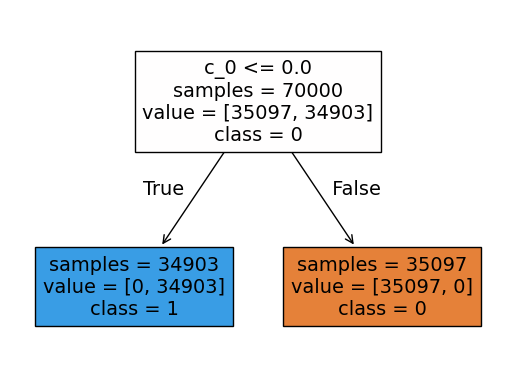

In [13]:
plot_tree(
    model,
    filled=True,
    feature_names=["c_0", "c_1"],
    class_names=["0", "1"],
    impurity=False,
)

Similarly, download data of quartic Galois extensions. This may take few minutes.

In [14]:
df_quartic_galois = get_data(
    degree=4,
    galois_only=True,
)

loading data: 100%|██████████| 19/19 [03:36<00:00, 11.41s/it]

Total number of fields: 182860


Q4. How many quartic Galois extensions in LMFDB?

In [15]:
len(df_quartic_galois)

182860

Q5. Train a decision tree model that predicts the Galois group of quartic Galois extensions.

- Randomly split the data into train (70\%) and test (30\%) set.
- Use the Dedekind zeta coefficients (up to $a_{1000}$) as features.
- The resulting model may achieve an accuracy $>$ 99\%.

In [16]:
X, y = X_y(
    df_quartic_galois,
    label="galois_label",
    feature="zeta",
    max_N=1000,
)
print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=float(0.3), random_state=42)
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
clr = classification_report(y_test, y_pred, digits=4)
print(clr)

Feature matrix shape: (182860, 1000)
Target vector shape: (182860, 1)
              precision    recall  f1-score   support

         4T1     1.0000    0.9994    0.9997      6614
         4T2     0.9999    1.0000    1.0000     48244

    accuracy                         0.9999     54858
   macro avg     1.0000    0.9997    0.9998     54858
weighted avg     0.9999    0.9999    0.9999     54858



Q6. Plot the tree and interpret it. Use `feature_names = [f"a_{i:04d}" for i in range(1, 1001)]` and `class_names=["4T1", "4T2"]`. Can you explain your observation?

Detailed answer can be found in the paper Lee-Lee (Figure 1, the tree may look slightly different).

[Text(0.2, 0.9444444444444444, 'a_0900 <= 0.5\nsamples = 128002\nvalue = [15259, 112743]\nclass = 4T2'),
 Text(0.1, 0.8333333333333334, 'samples = 12628\nvalue = [12628, 0]\nclass = 4T1'),
 Text(0.15000000000000002, 0.8888888888888888, 'True  '),
 Text(0.3, 0.8333333333333334, 'a_0529 <= 0.5\nsamples = 115374\nvalue = [2631, 112743]\nclass = 4T2'),
 Text(0.25, 0.8888888888888888, '  False'),
 Text(0.2, 0.7222222222222222, 'samples = 1576\nvalue = [1576, 0]\nclass = 4T1'),
 Text(0.4, 0.7222222222222222, 'a_0361 <= 0.5\nsamples = 113798\nvalue = [1055, 112743]\nclass = 4T2'),
 Text(0.3, 0.6111111111111112, 'samples = 614\nvalue = [614, 0]\nclass = 4T1'),
 Text(0.5, 0.6111111111111112, 'a_0961 <= 0.5\nsamples = 113184\nvalue = [441, 112743]\nclass = 4T2'),
 Text(0.4, 0.5, 'samples = 285\nvalue = [285, 0]\nclass = 4T1'),
 Text(0.6, 0.5, 'a_0196 <= 0.5\nsamples = 112899\nvalue = [156, 112743]\nclass = 4T2'),
 Text(0.5, 0.3888888888888889, 'samples = 104\nvalue = [104, 0]\nclass = 4T1'),
 Te

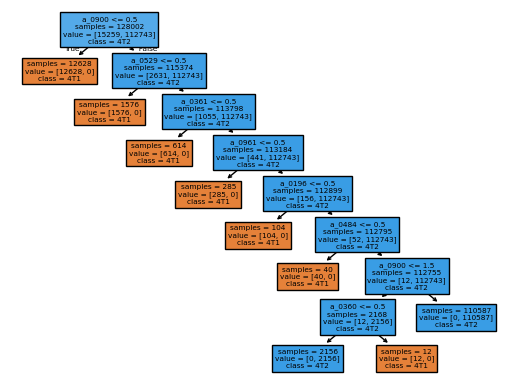

In [17]:
feature_names = [f"a_{i:04d}" for i in range(1, 1001)]
plot_tree(
    model,
    filled=True,
    feature_names=feature_names,
    class_names=["4T1", "4T2"],
    impurity=False,
)

The decision tree indicates that the square-indexed coefficients are more important than the others.
Moreover, one can conjecture that $a_{m^2}(K) = 0$ would imply $\mathrm{Gal}(K /\mathbb{Q}) \simeq \mathbb{Z} / 4$.
This can be proven by local computations, see Corollary 3.3 of Lee-Lee.

Q7. Do your own experiments (different model, different data, different problem, etc.).